<a href="https://colab.research.google.com/github/laurindodumba/PodAcademy_Prevenc-o-a-Fraude/blob/main/entendimento_dados.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# 0. Instalar pacotes e importar bibliotecas

In [1]:
!pip install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.6/11.6 MB 48.4 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from scipy.stats import mannwhitneyu

# 1. EDA

Leitura dos datasets principais

In [3]:
# Treino
train = pd.read_csv('/content/train.csv')

# Teste
test = pd.read_csv('/content/test.csv')

In [4]:
train.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_FRAUD
0,59383,2021-08-01 00:04:37,323,217,4.60,0
1,59384,2021-08-01 00:12:10,6,429,8.61,0
2,59385,2021-08-01 00:12:34,714,1011,64.00,0
3,59386,2021-08-01 00:15:40,266,1969,12.72,0
4,59387,2021-08-01 00:16:01,890,1482,98.88,0


In [5]:
test.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT
0,352590,2022-01-01 00:03:14,208,640,147.24
1,352591,2022-01-01 00:26:39,851,315,13.27
2,352592,2022-01-01 00:30:30,454,27,70.52
3,352593,2022-01-01 00:31:31,677,1573,44.75
4,352594,2022-01-01 00:56:18,322,1398,37.60


Avaliar quantidade de linhas

In [6]:
print(f'Quantidade de linhas no dataset de treino: {train.shape[0]}')
print(f'Quantidade de linhas no dataset de teste: {test.shape[0]}')

Quantidade de linhas no dataset de treino: 291231
Quantidade de linhas no dataset de teste: 226731


Leitura dos datasets auxiliares

In [7]:
terminal = pd.read_csv('/content/terminal.csv')
terminal.head()

,TERMINAL_ID,x_terminal_id,y_terminal_id
0,0,9.388886,44.298820
1,1,12.204779,38.423219
2,2,16.123444,41.642938
3,3,13.341542,37.858452
4,4,11.964165,55.351051


In [8]:
customer = pd.read_csv('/content/customer.csv')
customer.head()

,CUSTOMER_ID,x_customer_id,y_customer_id,mean_amount,std_amount,mean_nb_tx_per_day
0,0,10.950170,59.768684,62.262521,31.131260,2.179533
1,1,13.671851,52.775318,46.570785,23.285393,3.567092
2,2,-9.381829,38.617619,80.213879,40.106939,2.115580
3,3,-3.745116,40.551744,11.748426,5.874213,0.348517
4,4,4.312412,51.067100,78.924891,39.462446,3.480049


Join entre tabelas

In [9]:
# Treino
df_merged = pd.merge(train, customer, on='CUSTOMER_ID', how='left')
df_train_merged = pd.merge(df_merged, terminal, on='TERMINAL_ID', how='left')

# Teste
df_merged = pd.merge(test, customer, on='CUSTOMER_ID', how='left')
df_test_merged = pd.merge(df_merged, terminal, on='TERMINAL_ID', how='left')

df_train_merged.head()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_FRAUD,x_customer_id,y_customer_id,mean_amount,std_amount,mean_nb_tx_per_day,x_terminal_id,y_terminal_id
0,59383,2021-08-01 00:04:37,323,217,4.60,0,-0.362432,39.512573,7.353061,3.676530,3.324124,2.439994,50.324767
1,59384,2021-08-01 00:12:10,6,429,8.61,0,-0.466155,38.210214,18.618562,9.309281,3.778676,11.450431,49.902275
2,59385,2021-08-01 00:12:34,714,1011,64.00,0,-0.682848,38.095822,82.620413,41.310207,3.723765,13.616103,46.150744
3,59386,2021-08-01 00:15:40,266,1969,12.72,0,14.309093,40.607318,9.852171,4.926085,3.862067,12.286148,45.514582
4,59387,2021-08-01 00:16:01,890,1482,98.88,0,-4.209270,36.454733,83.660035,41.830018,3.128315,5.168861,51.234704


Metadados

In [10]:
# Metadados referente ao conjunto de dados
def pod_academy_generate_metadata(dataframe):
    """
    Gera um dataframe contendo metadados das colunas do dataframe fornecido.

    :param dataframe: DataFrame para o qual os metadados serão gerados.
    :return: DataFrame contendo metadados.
    """

    # Coleta de metadados básicos
    metadata = pd.DataFrame({
        'nome_variavel': dataframe.columns,
        'tipo': dataframe.dtypes,
        'qt_nulos': dataframe.isnull().sum(),
        'percent_nulos': round((dataframe.isnull().sum() / len(dataframe))* 100,2),
        'cardinalidade': dataframe.nunique(),
    })
    metadata=metadata.sort_values(by='percent_nulos',ascending=False)
    metadata = metadata.reset_index(drop=True)

    return metadata

pod_academy_generate_metadata(df_train_merged)

,nome_variavel,tipo,qt_nulos,percent_nulos,cardinalidade
0,TRANSACTION_ID,int64,0,0.0,291231
1,TX_DATETIME,object,0,0.0,287096
2,CUSTOMER_ID,int64,0,0.0,998
3,TERMINAL_ID,int64,0,0.0,1994
4,TX_AMOUNT,float64,0,0.0,18570
5,TX_FRAUD,int64,0,0.0,2
6,x_customer_id,float64,0,0.0,998
7,y_customer_id,float64,0,0.0,998
8,mean_amount,float64,0,0.0,998
9,std_amount,float64,0,0.0,998


Observamos que:
* O dataset principal está totalmente preenchido;
* Existem 998 clientes na base, estes clientes realizaram 291231 transações em 1994 terminais diferentes.

In [11]:
# Convertendo a coluna TX_DATETIME para datetime
df_train_merged['TX_DATETIME'] = pd.to_datetime(df_train_merged['TX_DATETIME'])
df_train_merged['year'] = df_train_merged['TX_DATETIME'].dt.year

# Função para classificar o período do dia
def classify_period(hour):
    if 5 <= hour < 12:
        return 'manhã'
    elif 12 <= hour < 18:
        return 'tarde'
    else:
        return 'noite'

# Aplicar a função para criar a nova coluna 'PERIODO_DIA'
df_train_merged['PERIODO_DIA'] = df_train_merged['TX_DATETIME'].dt.hour.apply(classify_period)

# Criando a variável que indica o mês de referência
df_train_merged['month_reference'] = df_train_merged['TX_DATETIME'].dt.strftime('%Y%m')
df_train_merged

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_FRAUD,x_customer_id,y_customer_id,mean_amount,std_amount,mean_nb_tx_per_day,x_terminal_id,y_terminal_id,year,PERIODO_DIA,month_reference
0,59383,2021-08-01 00:04:37,323,217,4.60,0,-0.362432,39.512573,7.353061,3.676530,3.324124,2.439994,50.324767,2021,noite,202108
1,59384,2021-08-01 00:12:10,6,429,8.61,0,-0.466155,38.210214,18.618562,9.309281,3.778676,11.450431,49.902275,2021,noite,202108
2,59385,2021-08-01 00:12:34,714,1011,64.00,0,-0.682848,38.095822,82.620413,41.310207,3.723765,13.616103,46.150744,2021,noite,202108
3,59386,2021-08-01 00:15:40,266,1969,12.72,0,14.309093,40.607318,9.852171,4.926085,3.862067,12.286148,45.514582,2021,noite,202108
4,59387,2021-08-01 00:16:01,890,1482,98.88,0,-4.209270,36.454733,83.660035,41.830018,3.128315,5.168861,51.234704,2021,noite,202108
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
291226,350609,2021-12-30 23:33:02,221,41,61.26,0,16.458186,48.474966,78.232912,39.116456,2.943576,0.726690,51.074300,2021,noite,202112
291227,350610,2021-12-30 23:46:15,101,761,58.80,0,-4.763890,37.754536,36.036584,18.018292,0.930977,10.757077,47.182099,2021,noite,202112
291228,350611,2021-12-30 23:54:38,7,1991,15.08,0,14.722394,49.992092,30.132783,15.066392,3.096935,11.532585,60.306354,2021,noite,202112
291229,350612,2021-12-30 23:56:36,161,1166,54.24,0,-3.076024,43.274381,70.068772,35.034386,2.627048,-2.184463,42.013333,2021,noite,202112


* Testes de sanidade
  * Checagem dos principais números, alguns exemplos:
    * Taxa de fraude na base;
    * Taxa de fraude por mês de referência;
    * Taxa de fraude por terminal;
    * Volume de transações no período, por mês de referência e por terminal;
    * Volume de clientes que estiveram envolvidos em alguma transação fraudulenta e por mês de referência;
    * Volume de dinheiro nas transações fraudulentas no período e por mês de referência;
    * Volume de transações, dinheiro por período do dia.

## 1.1 Taxa de fraude na base

In [12]:
# Estatística descritiva
df_train_merged.describe()

,TRANSACTION_ID,TX_DATETIME,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_FRAUD,x_customer_id,y_customer_id,mean_amount,std_amount,mean_nb_tx_per_day,x_terminal_id,y_terminal_id,year
count,291231.000000,291231,291231.000000,291231.000000,291231.000000,291231.000000,291231.000000,291231.000000,291231.000000,291231.000000,291231.000000,291231.000000,291231.000000,291231.0
mean,204998.000000,2021-10-16 02:06:44.044813056,496.256202,993.718526,53.182274,0.022601,6.369599,46.715810,51.710394,25.855197,2.650934,6.929841,46.906274,2021.0
min,59383.000000,2021-08-01 00:04:37,0.000000,0.000000,0.000000,0.000000,-15.722968,36.442978,5.063101,2.531550,0.018782,-16.913020,34.480700,2021.0
25%,132190.500000,2021-09-08 05:17:43.500000,249.000000,496.000000,21.130000,0.000000,-0.691936,40.348956,28.606102,14.303051,1.956902,0.274440,40.835133,2021.0
50%,204998.000000,2021-10-16 05:55:26,498.000000,1000.000000,44.770000,0.000000,8.429219,48.108743,51.641807,25.820903,2.836935,8.534868,47.972450,2021.0
75%,277805.500000,2021-11-23 06:15:18.500000,741.000000,1483.000000,76.850000,0.000000,12.479186,51.567670,75.288972,37.644486,3.438147,12.748856,51.636076,2021.0
max,350613.000000,2021-12-30 23:58:21,999.000000,1999.000000,291.150000,1.000000,25.192465,60.406826,99.981815,49.990907,3.999725,26.843163,64.060717,2021.0
std,84071.292461,NaN,285.274966,575.267551,39.573329,0.148627,8.551536,6.486223,27.475610,13.737805,0.961907,8.708658,6.408352,0.0


Verificamos que o volume de transações é 291231 e a taxa de fraude na base é 2,26%.

## 1.2 Volume de transações e Taxa de fraude por mês de referência

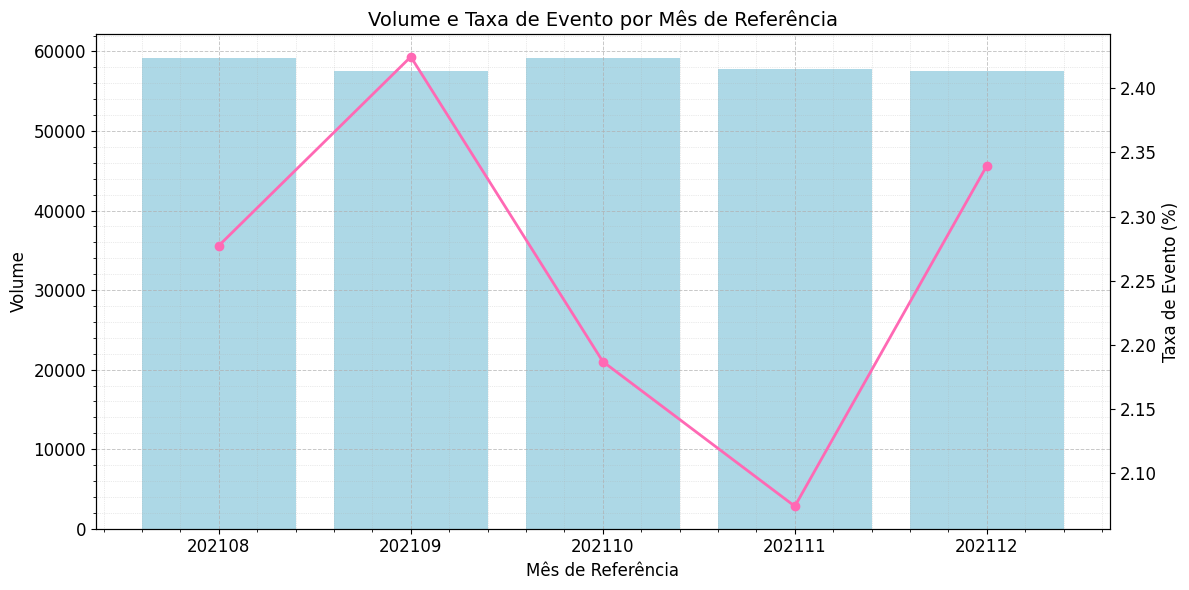

In [13]:
# Preparando os DataFrames
df_ref_vol = df_train_merged.groupby('month_reference')['TRANSACTION_ID'].count().reset_index().rename(columns={'TRANSACTION_ID': 'Volume'})
df_ref_fraud = df_train_merged.groupby('month_reference')['TX_FRAUD'].mean().reset_index()
df_plot = pd.merge(df_ref_fraud, df_ref_vol, how='inner', on='month_reference')

# Gráfico com barras para o volume e linha para a taxa de evento por month_reference
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotando o gráfico de barras para o volume
color_bar = 'lightblue'
ax1.bar(df_plot['month_reference'], df_plot['Volume'], color=color_bar, label='Volume')
ax1.set_xlabel('Mês de Referência', fontsize=12, color='black')
ax1.set_ylabel('Volume', color='black', fontsize=12)
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True, which='major', linestyle='--', linewidth=0.7, alpha=0.7)
ax1.grid(True, which='minor', linestyle=':', linewidth=0.5, alpha=0.5)

# Configurando eixos menores para melhorar a visualização do grid
ax1.minorticks_on()

# Plotando o gráfico de linha para a taxa de fraude
color_line = 'hotpink'
ax2 = ax1.twinx()  # Cria um segundo eixo y
ax2.plot(df_plot['month_reference'], df_plot['TX_FRAUD'] * 100, marker='o', linestyle='-', color=color_line, linewidth=2, markersize=6, label='Taxa de Evento (%)')
ax2.set_ylabel('Taxa de Evento (%)', color='black', fontsize=12)
ax2.tick_params(axis='y', labelcolor='black')

# Ajustando a fonte e cor dos labels dos eixos
for label in ax1.get_xticklabels() + ax1.get_yticklabels() + ax2.get_yticklabels():
    label.set_fontsize(12)
    label.set_color('black')

plt.title('Volume e Taxa de Evento por Mês de Referência', fontsize=14, color='black')
fig.tight_layout()
plt.xticks(rotation=45, ha='right')
plt.grid(False)
plt.show()

In [14]:
df_plot

,month_reference,TX_FRAUD,Volume
0,202108,0.022773,59193
1,202109,0.024244,57582
2,202110,0.021871,59166
3,202111,0.020744,57800
4,202112,0.023395,57490


Podemos notar que os valores máximo e mínimo de taxa de fraude são, respectivamente, 2,42% e 2,07% tendo ocorrido em setembro de 2021 e novembro de 2021, nesta ordem. Além disso, observamos que o volume de transações é estável ao longo do período.

## 1.3 Volume de transações e Taxa de fraude por terminal

### 1.3.1 Ordenando por terminais com maior taxa de fraude

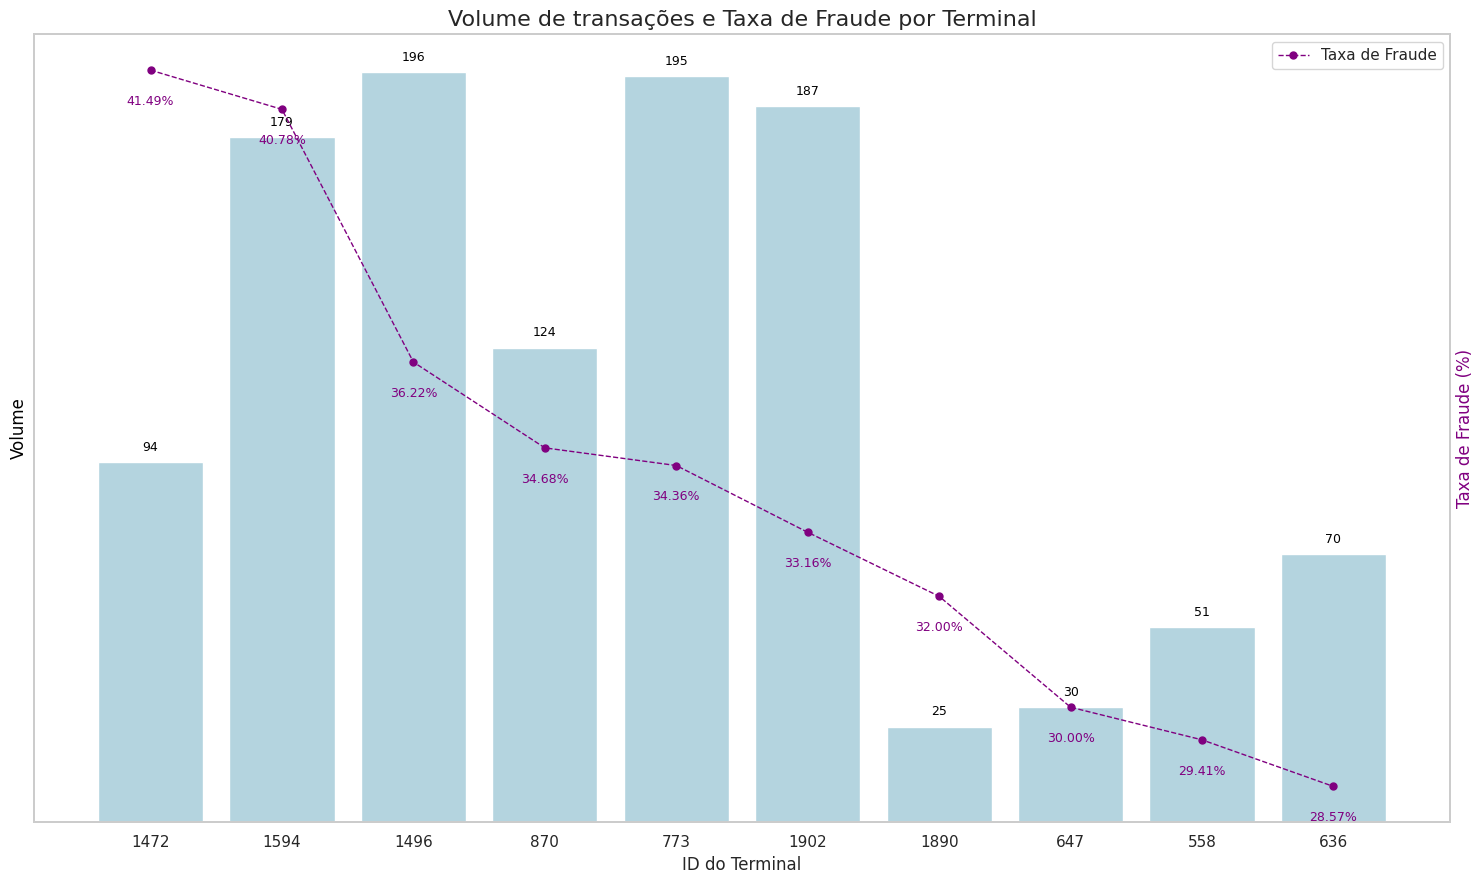

In [15]:
df_ref_vol = df_train_merged.groupby('TERMINAL_ID')['TRANSACTION_ID'].count().reset_index().rename(columns={'TRANSACTION_ID': 'VOLUME'})
df_ref_fraud = df_train_merged.groupby('TERMINAL_ID')['TX_FRAUD'].mean().reset_index()
df_plot = pd.merge(df_ref_fraud, df_ref_vol, how='inner', on='TERMINAL_ID')
df_plot = df_plot.sort_values(by=['TX_FRAUD','VOLUME'],ascending=False)[:10].copy()

# Definindo o estilo do seaborn
sns.set(style="whitegrid")

# Criando a figura e o eixo
fig, ax1 = plt.subplots(figsize=(15, 9))

# Plotando o gráfico de barras
barplot = sns.barplot(x=df_plot['TERMINAL_ID'].astype(str),
                      y=df_plot['VOLUME'],
                      color='lightblue',
                      ax=ax1)

# Criando o segundo eixo y para a linha de TX_FRAUD
ax2 = ax1.twinx()
lineplot = ax2.plot(df_plot['TERMINAL_ID'].astype(str),
                     df_plot['TX_FRAUD'],
                     color='purple',
                     marker='o',
                     linestyle='--',
                     linewidth=1,
                     markersize=5,
                     label='Taxa de Fraude')

# Ajustando os rótulos e título
ax1.set_xlabel('ID do Terminal', fontsize=12)
ax1.set_ylabel('Volume', fontsize=12, color='black')
ax2.set_ylabel('Taxa de Fraude (%)', fontsize=12, color='purple')
plt.title('Volume de transações e Taxa de Fraude por Terminal', fontsize=16)
ax1.tick_params(axis='y', labelcolor='black')
ax2.tick_params(axis='y', labelcolor='purple')
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)

# Removendo todas as linhas de grade
ax1.grid(False)
ax2.grid(False)

# Removendo números dos eixos verticais
ax1.set_yticks([])
ax2.set_yticks([])

# Adicionando rótulos nas barras
for i in range(len(df_plot)):
    total_value = df_plot['VOLUME'].iloc[i]
    ax1.annotate(f'{total_value}',
                 (df_plot['TERMINAL_ID'].astype(str).iloc[i], df_plot['VOLUME'].iloc[i]),
                 textcoords="offset points", xytext=(0,8), ha='center', fontsize=9, color='black')

# Adicionando rótulos na curva
for i in range(len(df_plot)):
    fraud_rate = df_plot['TX_FRAUD'].iloc[i]
    ax2.annotate(f'{100*fraud_rate:.2f}%',
                 (df_plot['TERMINAL_ID'].astype(str).iloc[i], df_plot['TX_FRAUD'].iloc[i]),
                 textcoords="offset points", xytext=(0,-25), ha='center', fontsize=9, color='purple')

# Adicionando a legenda para a linha de TX_FRAUD
ax2.legend(['Taxa de Fraude'], loc='upper right')

# Ajustando o layout para melhor visualização
plt.tight_layout()

# Exibindo o gráfico
plt.show()

### 1.4.1 Ordenando por terminais com maior volume de transações

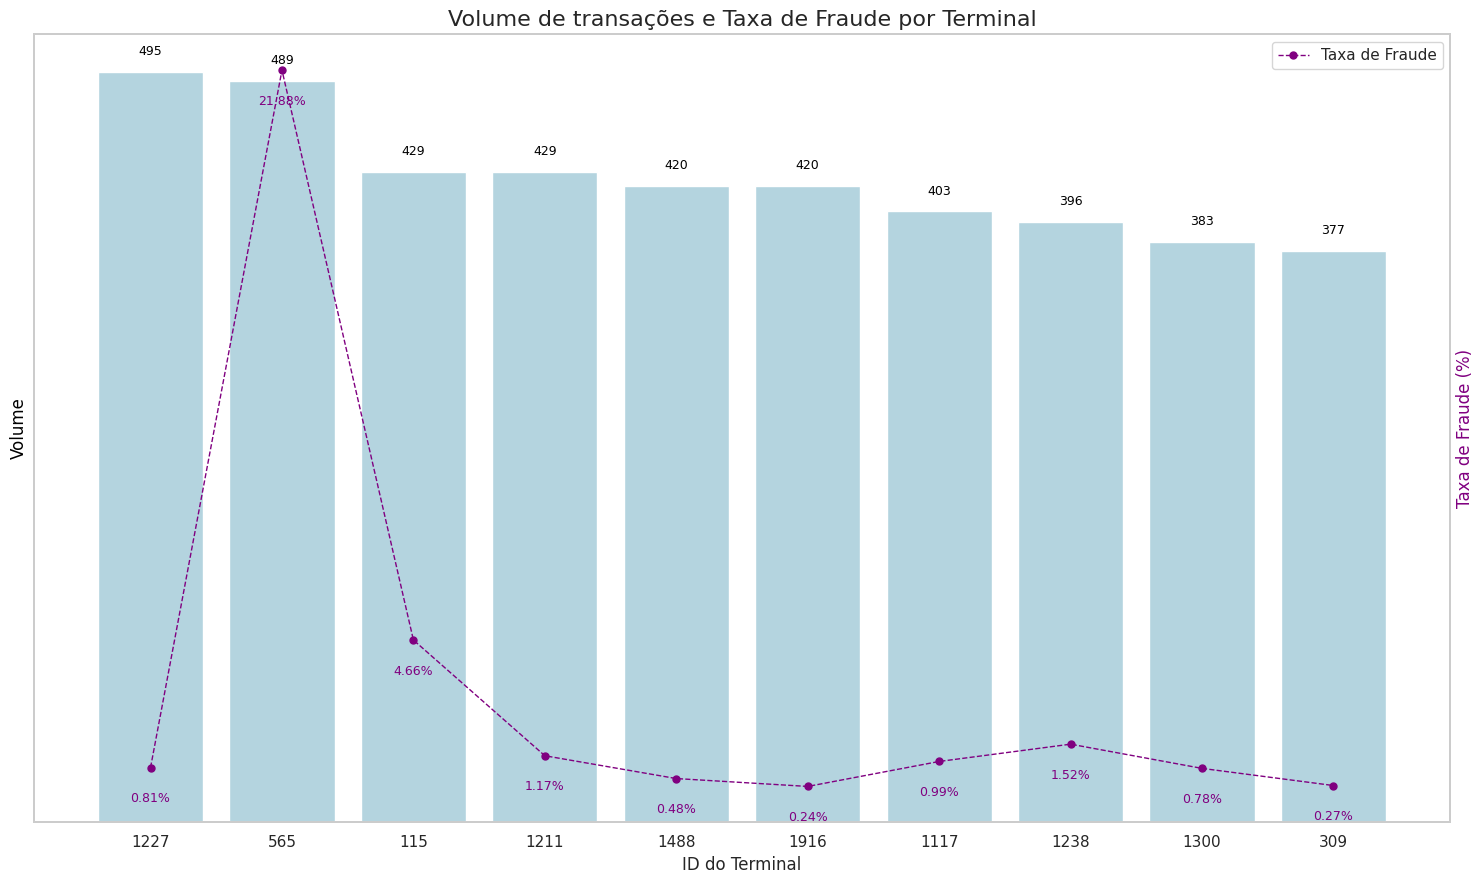

In [16]:
df_ref_vol = df_train_merged.groupby('TERMINAL_ID')['TRANSACTION_ID'].count().reset_index().rename(columns={'TRANSACTION_ID': 'VOLUME'})
df_ref_fraud = df_train_merged.groupby('TERMINAL_ID')['TX_FRAUD'].mean().reset_index()
df_plot = pd.merge(df_ref_fraud, df_ref_vol, how='inner', on='TERMINAL_ID')
df_plot = df_plot.sort_values(by=['VOLUME','TX_FRAUD'],ascending=False)[:10].copy()

# Definindo o estilo do seaborn
sns.set(style="whitegrid")

# Criando a figura e o eixo
fig, ax1 = plt.subplots(figsize=(15, 9))

# Plotando o gráfico de barras
barplot = sns.barplot(x=df_plot['TERMINAL_ID'].astype(str),
                      y=df_plot['VOLUME'],
                      color='lightblue',
                      ax=ax1)

# Criando o segundo eixo y para a linha de TX_FRAUD
ax2 = ax1.twinx()
lineplot = ax2.plot(df_plot['TERMINAL_ID'].astype(str),
                     df_plot['TX_FRAUD'],
                     color='purple',
                     marker='o',
                     linestyle='--',
                     linewidth=1,
                     markersize=5,
                     label='Taxa de Fraude')

# Ajustando os rótulos e título
ax1.set_xlabel('ID do Terminal', fontsize=12)
ax1.set_ylabel('Volume', fontsize=12, color='black')
ax2.set_ylabel('Taxa de Fraude (%)', fontsize=12, color='purple')
plt.title('Volume de transações e Taxa de Fraude por Terminal', fontsize=16)
ax1.tick_params(axis='y', labelcolor='black')
ax2.tick_params(axis='y', labelcolor='purple')
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)

# Removendo todas as linhas de grade
ax1.grid(False)
ax2.grid(False)

# Removendo números dos eixos verticais
ax1.set_yticks([])
ax2.set_yticks([])

# Adicionando rótulos nas barras
for i in range(len(df_plot)):
    total_value = df_plot['VOLUME'].iloc[i]
    ax1.annotate(f'{total_value}',
                 (df_plot['TERMINAL_ID'].astype(str).iloc[i], df_plot['VOLUME'].iloc[i]),
                 textcoords="offset points", xytext=(0,12), ha='center', fontsize=9, color='black')

# Adicionando rótulos na curva
for i in range(len(df_plot)):
    fraud_rate = df_plot['TX_FRAUD'].iloc[i]
    ax2.annotate(f'{100*fraud_rate:.2f}%',
                 (df_plot['TERMINAL_ID'].astype(str).iloc[i], df_plot['TX_FRAUD'].iloc[i]),
                 textcoords="offset points", xytext=(0,-25), ha='center', fontsize=9, color='purple')

# Adicionando a legenda para a linha de TX_FRAUD
ax2.legend(['Taxa de Fraude'], loc='upper right')

# Ajustando o layout para melhor visualização
plt.tight_layout()

# Exibindo o gráfico
plt.show()

In [17]:
# Razão entre a taxa de fraude no terminal 565 e a taxa média
df_plot.iloc[1].TX_FRAUD/df_train_merged.TX_FRAUD.mean()

9.681767340935401

O terminal 565 possui o segundo maior volume de transações (489) e apresenta uma taxa de fraude bastante elevada, correspondendo a cerca de 9,68 vezes maior que a taxa média de fraude no dataset.

## 1.4 Volume de clientes que estiveram envolvidos em alguma transação fraudulenta e por mês de referência

In [18]:
# Calculando a quantidade de clientes envolvidos em transações fraudulentas
qtd_clientes_fraud = df_train_merged[df_train_merged.TX_FRAUD == 1].CUSTOMER_ID.nunique()

# Total de clientes
total_clientes = df_train_merged.CUSTOMER_ID.nunique()

# Calculando a representação percentual
percentual_fraud = 100 * qtd_clientes_fraud / total_clientes

print(f'Quantidade de clientes envolvidos em alguma transação fraudulenta no período: {qtd_clientes_fraud}\nTotal de clientes: {total_clientes}\nRepresentação percentual {percentual_fraud:.2f}%')

Quantidade de clientes envolvidos em alguma transação fraudulenta no período: 750
Total de clientes: 998
Representação percentual 75.15%


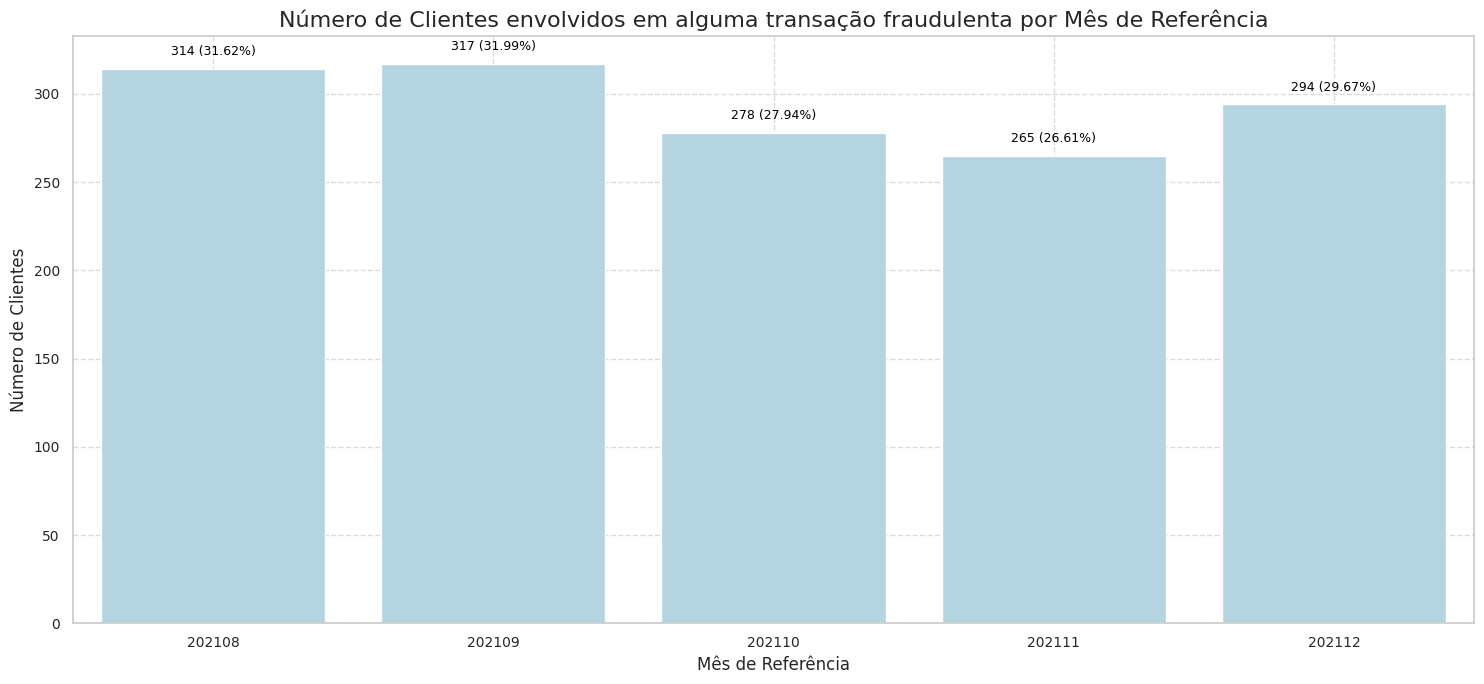

In [19]:
df_total_customers = df_train_merged.groupby('month_reference')['CUSTOMER_ID'].nunique().reset_index()
df_total_customers = df_total_customers.rename(columns={'CUSTOMER_ID': 'Total_Customers'})

df_fraud_customers = df_train_merged[df_train_merged.TX_FRAUD == 1].groupby('month_reference')['CUSTOMER_ID'].nunique().reset_index()
df_fraud_customers = df_fraud_customers.rename(columns={'CUSTOMER_ID': 'Fraud_Customers'})

# Mesclando os DataFrames para ter total e fraudulento juntos
df_comparison = pd.merge(df_total_customers, df_fraud_customers, on='month_reference', how='inner')
df_comparison['Percent_Fraud'] = (df_comparison['Fraud_Customers'] / df_comparison['Total_Customers']) * 100

# Definindo o estilo do seaborn
sns.set(style="whitegrid")

# Plotando o gráfico de barras
plt.figure(figsize=(15, 7))
barplot = sns.barplot(x=df_comparison['month_reference'].astype(str),
                      y=df_comparison['Fraud_Customers'],
                      color='lightblue')

# Ajustando os rótulos e título
plt.xlabel('Mês de Referência', fontsize=12)
plt.ylabel('Número de Clientes', fontsize=12)
plt.title('Número de Clientes envolvidos em alguma transação fraudulenta por Mês de Referência', fontsize=16)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Adicionando anotações para número de clientes e percentual
for i in range(len(df_comparison)):
    num_clients = df_comparison['Fraud_Customers'].iloc[i]
    percent_fraud = df_comparison['Percent_Fraud'].iloc[i]
    plt.annotate(f'{num_clients} ({percent_fraud:.2f}%)',
                 (df_comparison['month_reference'].astype(str).iloc[i], df_comparison['Fraud_Customers'].iloc[i]),
                 textcoords="offset points", xytext=(0,10), ha='center', fontsize=9, color='black')

plt.show()

Em setembro de 2021, tivemos 317 clientes envolvidos em transações fraudulentas. Este valor representa 31,99% do total de clientes que realizaram alguma transação naquele mês.

Em novembro de 2021, notamos que houve uma redução neste número. 265 clientes estiveram envolvidos em alguma transação fraudulenta, representando 26,61% do total de clientes que realizaram alguma transação naquele mês.

## 1.5 Volume de dinheiro nas transações fraudulentas no período e por mês de referência

Valor total envolvido em transações fraudulentas no período: 376210.13


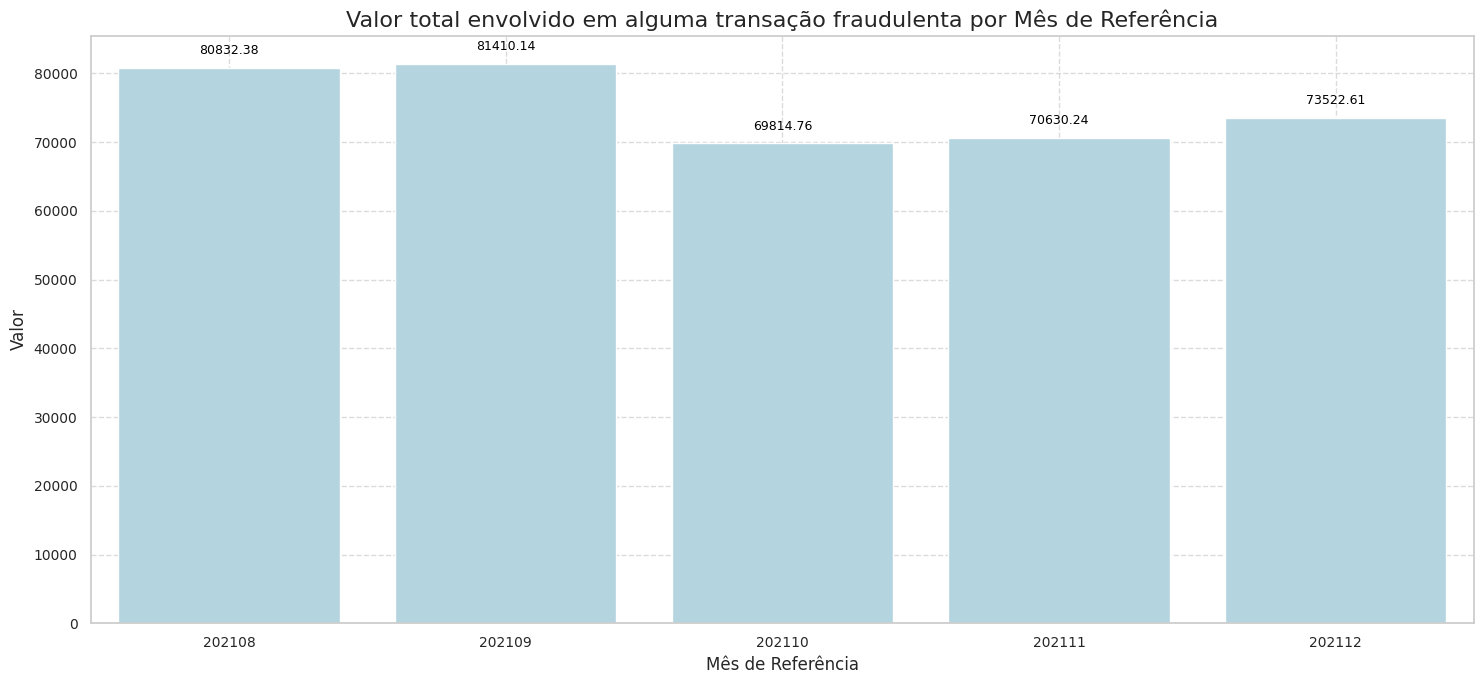

In [20]:
df_amount = df_train_merged[df_train_merged.TX_FRAUD == 1].groupby('month_reference')['TX_AMOUNT'].sum().reset_index()

valor_total = df_amount.TX_AMOUNT.sum()

# Definindo o estilo do seaborn
sns.set(style="whitegrid")

# Plotando o gráfico de barras
plt.figure(figsize=(15, 7))
barplot = sns.barplot(x=df_amount['month_reference'].astype(str),
                      y=df_amount['TX_AMOUNT'],
                      color='lightblue')

# Ajustando os rótulos e título
plt.xlabel('Mês de Referência', fontsize=12)
plt.ylabel('Valor', fontsize=12)
plt.title('Valor total envolvido em alguma transação fraudulenta por Mês de Referência', fontsize=16)
plt.xticks(rotation=0, fontsize=10)
plt.yticks(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Adicionando anotações para número de clientes e percentual
for i in range(len(df_amount)):
    total_value_month_ref = df_amount['TX_AMOUNT'].iloc[i]
    plt.annotate(f'{total_value_month_ref}',
                 (df_amount['month_reference'].astype(str).iloc[i], df_amount['TX_AMOUNT'].iloc[i]),
                 textcoords="offset points", xytext=(0,10), ha='center', fontsize=9, color='black')

print(f'Valor total envolvido em transações fraudulentas no período: {valor_total}')

plt.show()

## 1.6 Distribuição de valor de transação por grupo (Fraude / Não Fraude)

### 1.6.1 Análise Gráfica

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


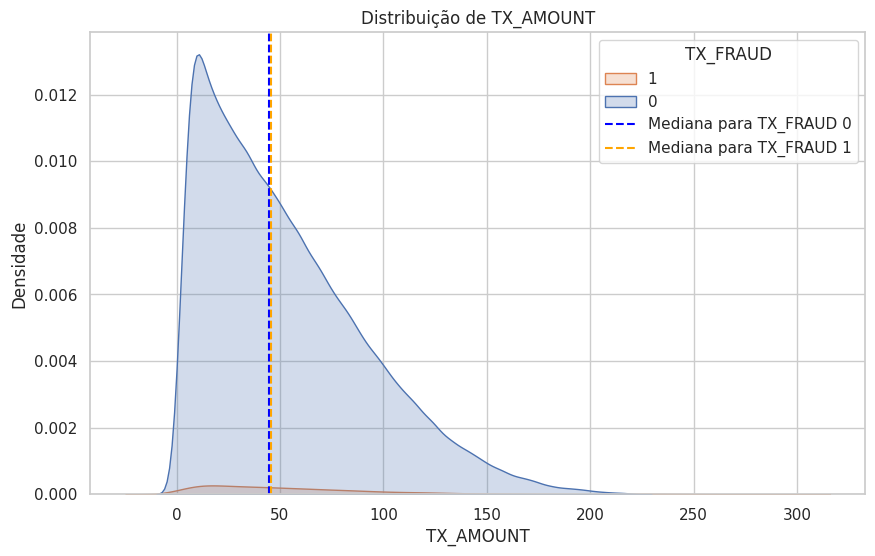

In [21]:
var = 'TX_AMOUNT'

# Calcular as medianas para cada grupo
medianas = df_train_merged.groupby('TX_FRAUD')[var].median()

colors = ['blue','orange']
i = 0

plt.figure(figsize=(10, 6))
sns.kdeplot(data=df_train_merged, x=var, hue='TX_FRAUD', fill=True, warn_singular=False)

# Adicionar linhas verticais representando as medianas
for target, mediana in medianas.items():
    plt.axvline(x=mediana, linestyle='--', color=colors[i], label=f'Mediana para TX_FRAUD {target}')
    i += 1

plt.title(f'Distribuição de {var}')
plt.ylabel('Densidade')
plt.xlabel(f'{var}')
plt.legend(title='TX_FRAUD', loc='upper right', labels=['1', '0', 'Mediana para TX_FRAUD 0', 'Mediana para TX_FRAUD 1'])
plt.show()

### 1.6.2 Teste de Mann-Whitney U (Não paramétrico)

In [22]:
# Definindo os dois grupos
amostra1 = df_train_merged[train.TX_FRAUD == 0]['TX_AMOUNT']
amostra2 = df_train_merged[train.TX_FRAUD == 1]['TX_AMOUNT']

In [23]:
# Realizando o teste de Mann-Whitney U
stat, p_value = mannwhitneyu(amostra1, amostra2, alternative='less')

print(f'Estatística U: {stat}')
print(f'Valor p: {p_value}')

if p_value < 0.05:
    print("Rejeitamos a hipótese nula. Há uma diferença estatisticamente significativa entre os grupos.")
else:
    print("Não rejeitamos a hipótese nula. Não podemos afirmar que há diferença estatisticamente significativa entre os grupos.")

Estatística U: 918469532.5
Valor p: 0.0033098149945866543
Rejeitamos a hipótese nula. Há uma diferença estatisticamente significativa entre os grupos.


## 1.7 Volume de transações, dinheiro por período do dia

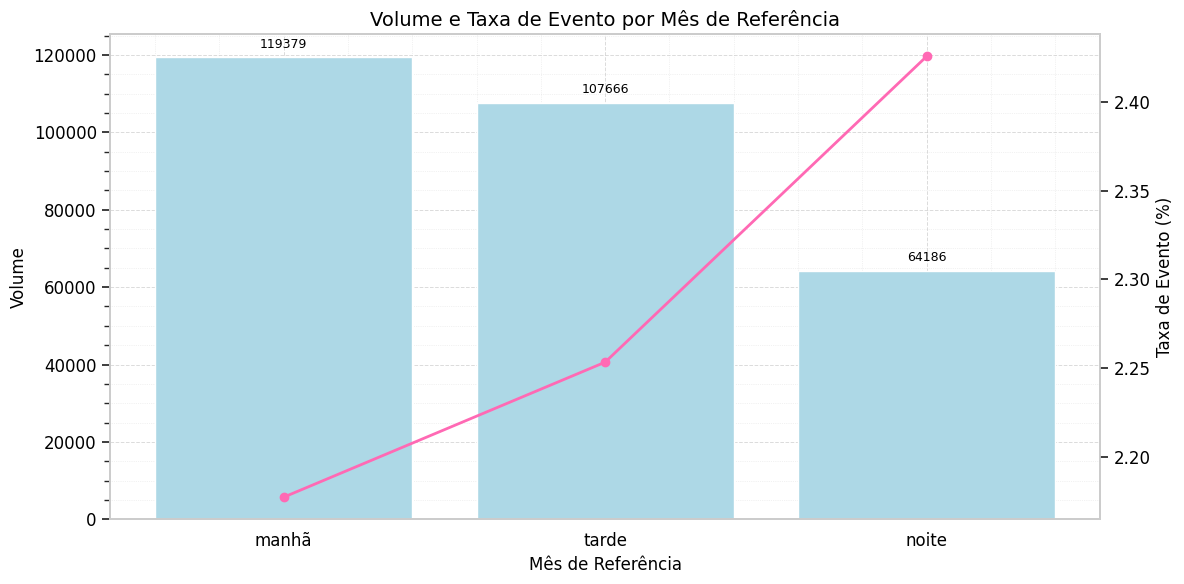

In [24]:
# Preparando os DataFrames
df_ref_vol = df_train_merged.groupby('PERIODO_DIA')['TRANSACTION_ID'].count().reset_index().rename(columns={'TRANSACTION_ID': 'Volume'})
df_ref_fraud = df_train_merged.groupby('PERIODO_DIA')['TX_FRAUD'].mean().reset_index()
df_plot = pd.merge(df_ref_fraud, df_ref_vol, how='inner', on='PERIODO_DIA')

# Definir uma ordem personalizada para a coluna 'PERIODO_DIA'
ordem_periodos = ['manhã', 'tarde', 'noite']
df_plot['PERIODO_DIA'] = pd.Categorical(df_plot['PERIODO_DIA'], categories=ordem_periodos, ordered=True)

# Ordenar o DataFrame pela coluna 'PERIODO_DIA'
df_plot = df_plot.sort_values(by='PERIODO_DIA')

# Gráfico com barras para o volume e linha para a taxa de evento por PERIODO_DIA
fig, ax1 = plt.subplots(figsize=(12, 6))

# Plotando o gráfico de barras para o volume
color_bar = 'lightblue'
ax1.bar(df_plot['PERIODO_DIA'], df_plot['Volume'], color=color_bar, label='Volume')
ax1.set_xlabel('Mês de Referência', fontsize=12, color='black')
ax1.set_ylabel('Volume', color='black', fontsize=12)
ax1.tick_params(axis='y', labelcolor='black')
ax1.grid(True, which='major', linestyle='--', linewidth=0.7, alpha=0.7)
ax1.grid(True, which='minor', linestyle=':', linewidth=0.5, alpha=0.5)

# Configurando eixos menores para melhorar a visualização do grid
ax1.minorticks_on()

# Plotando o gráfico de linha para a taxa de fraude
color_line = 'hotpink'
ax2 = ax1.twinx()  # Cria um segundo eixo y
ax2.plot(df_plot['PERIODO_DIA'], df_plot['TX_FRAUD'] * 100, marker='o', linestyle='-', color=color_line, linewidth=2, markersize=6, label='Taxa de Evento (%)')
ax2.set_ylabel('Taxa de Evento (%)', color='black', fontsize=12)
ax2.tick_params(axis='y', labelcolor='black')

# Ajustando a fonte e cor dos labels dos eixos
for label in ax1.get_xticklabels() + ax1.get_yticklabels() + ax2.get_yticklabels():
    label.set_fontsize(12)
    label.set_color('black')

# Adicionando rótulos nas barras
for i in range(len(df_plot)):
    total_value = df_plot['Volume'].iloc[i]
    ax1.annotate(f'{total_value}',
                 (df_plot['PERIODO_DIA'].astype(str).iloc[i], df_plot['Volume'].iloc[i]),
                 textcoords="offset points", xytext=(0,7), ha='center', fontsize=9, color='black')

plt.title('Volume e Taxa de Evento por Mês de Referência', fontsize=14, color='black')
fig.tight_layout()
plt.xticks(rotation=45, ha='right')
plt.grid(False)
plt.show()

Observamos que:
  * O volume maior de transações ocorre na manhã e tarde;
  * A taxa de fraude é mais elevada no período da noite.

In [25]:
df_plot

,PERIODO_DIA,TX_FRAUD,Volume
0,manhã,0.021771,119379
2,tarde,0.022533,107666
1,noite,0.024258,64186


### 1.7.2 Distribuição de valor de transação para os grupos (TX_FRAUD = 0 / TX_FRAUD = 1) por período do dia

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


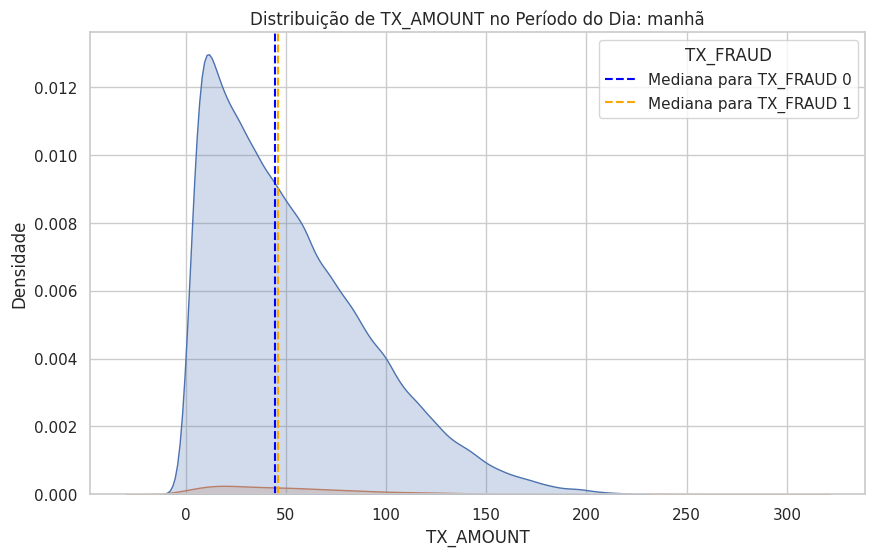

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


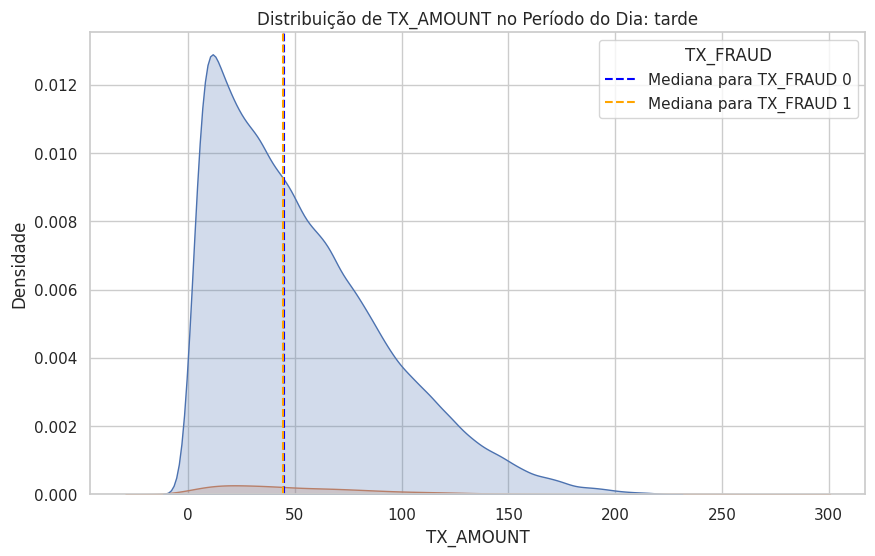

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


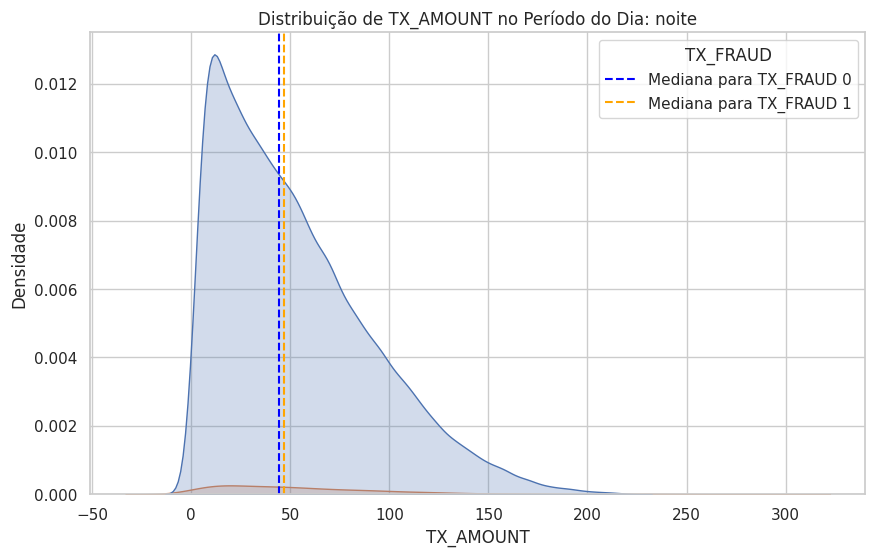

In [26]:
# Definir cores
colors = ['blue', 'orange']

# Iterar sobre cada período do dia e plotar o gráfico correspondente
for periodo in ordem_periodos:
    plt.figure(figsize=(10, 6))

    # Filtrar os dados para o período atual
    subset = df_train_merged[df_train_merged['PERIODO_DIA'] == periodo]

    # Calcular as medianas para cada grupo
    medianas = subset.groupby('TX_FRAUD')['TX_AMOUNT'].median()

    # Plotar a densidade
    sns.kdeplot(data=subset, x='TX_AMOUNT', hue='TX_FRAUD', fill=True, warn_singular=False)

    # Adicionar linhas verticais representando as medianas
    for i, (target, mediana) in enumerate(medianas.items()):
        plt.axvline(x=mediana, linestyle='--', color=colors[i], label=f'Mediana para TX_FRAUD {target}')

    plt.title(f'Distribuição de TX_AMOUNT no Período do Dia: {periodo}')
    plt.ylabel('Densidade')
    plt.xlabel('TX_AMOUNT')
    plt.legend(title='TX_FRAUD', loc='upper right')
    plt.show()

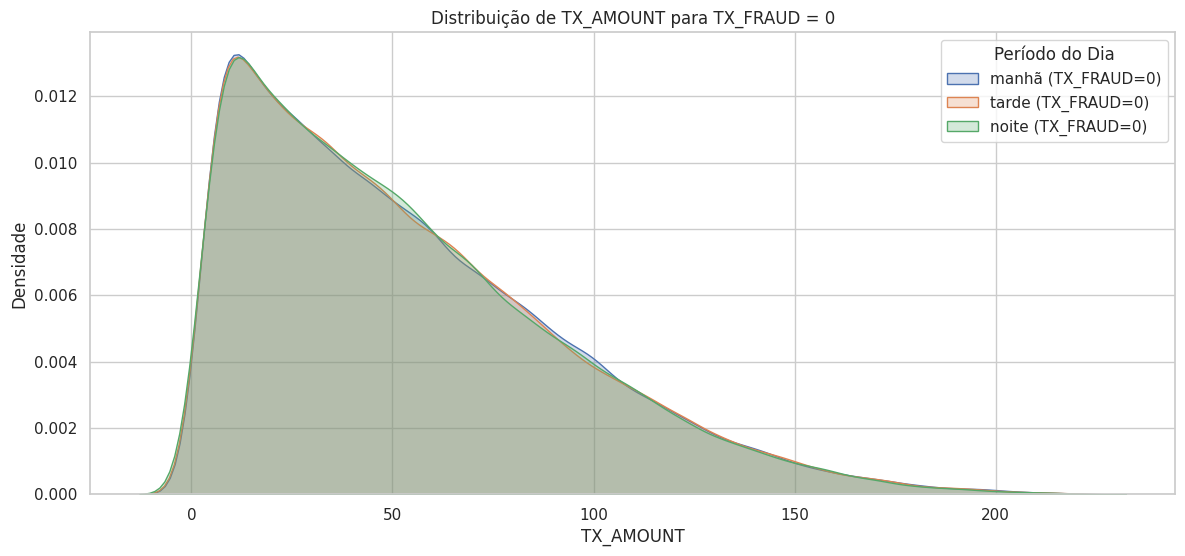

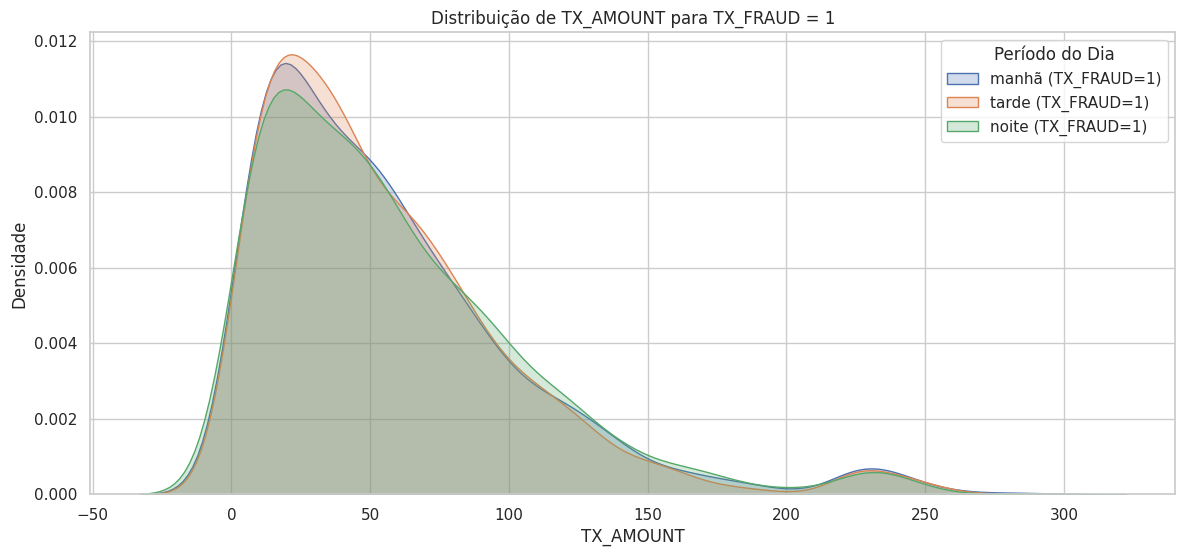

In [27]:
# Plot para TX_FRAUD = 0
plt.figure(figsize=(14, 6))
for periodo in ordem_periodos:
    subset = df_train_merged[(df_train_merged['PERIODO_DIA'] == periodo) & (df_train_merged['TX_FRAUD'] == 0)]
    sns.kdeplot(data=subset, x='TX_AMOUNT', fill=True, label=f'{periodo} (TX_FRAUD=0)', warn_singular=False)

plt.title('Distribuição de TX_AMOUNT para TX_FRAUD = 0')
plt.ylabel('Densidade')
plt.xlabel('TX_AMOUNT')
plt.legend(title='Período do Dia')
plt.show()

# Plot para TX_FRAUD = 1
plt.figure(figsize=(14, 6))
for periodo in ordem_periodos:
    subset = df_train_merged[(df_train_merged['PERIODO_DIA'] == periodo) & (df_train_merged['TX_FRAUD'] == 1)]
    sns.kdeplot(data=subset, x='TX_AMOUNT', fill=True, label=f'{periodo} (TX_FRAUD=1)', warn_singular=False)

plt.title('Distribuição de TX_AMOUNT para TX_FRAUD = 1')
plt.ylabel('Densidade')
plt.xlabel('TX_AMOUNT')
plt.legend(title='Período do Dia')
plt.show()

## 1.8 Visualização gráfica dos terminais

### 1.8.1 Localizações dos clientes

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_ocean.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_physical/ne_110m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/110m_cultural/ne_110m_admin_0_boundary_lines_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


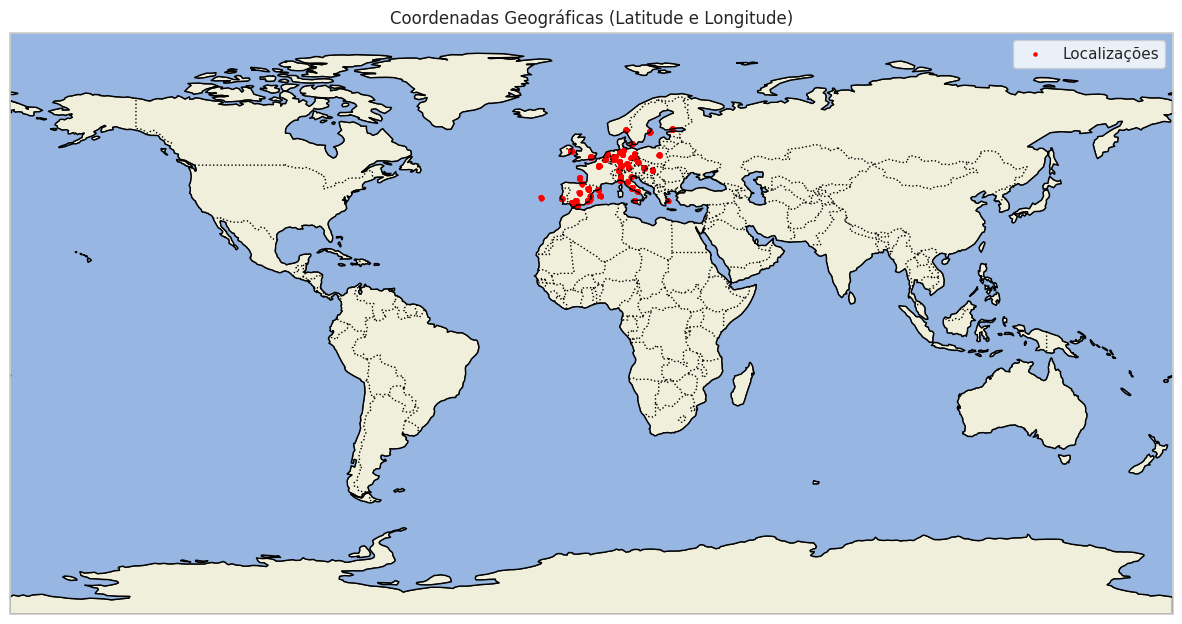

In [28]:
# Criando o plot com Cartopy
plt.figure(figsize=(15, 8))
ax = plt.axes(projection=ccrs.PlateCarree())  # Define a projeção para o gráfico
ax.set_extent([-180, 180, -90, 90])  # Define os limites do gráfico (global)

# Adiciona características ao mapa como costas, estados e países
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.OCEAN)

# Plotando as coordenadas no mapa
plt.scatter(customer['x_customer_id'], customer['y_customer_id'],
            color='red', marker='o', s=5, transform=ccrs.PlateCarree(),
            label='Localizações')

plt.title('Coordenadas Geográficas (Latitude e Longitude)')
plt.legend()
plt.show()

### 1.8.2 Localizações dos terminais

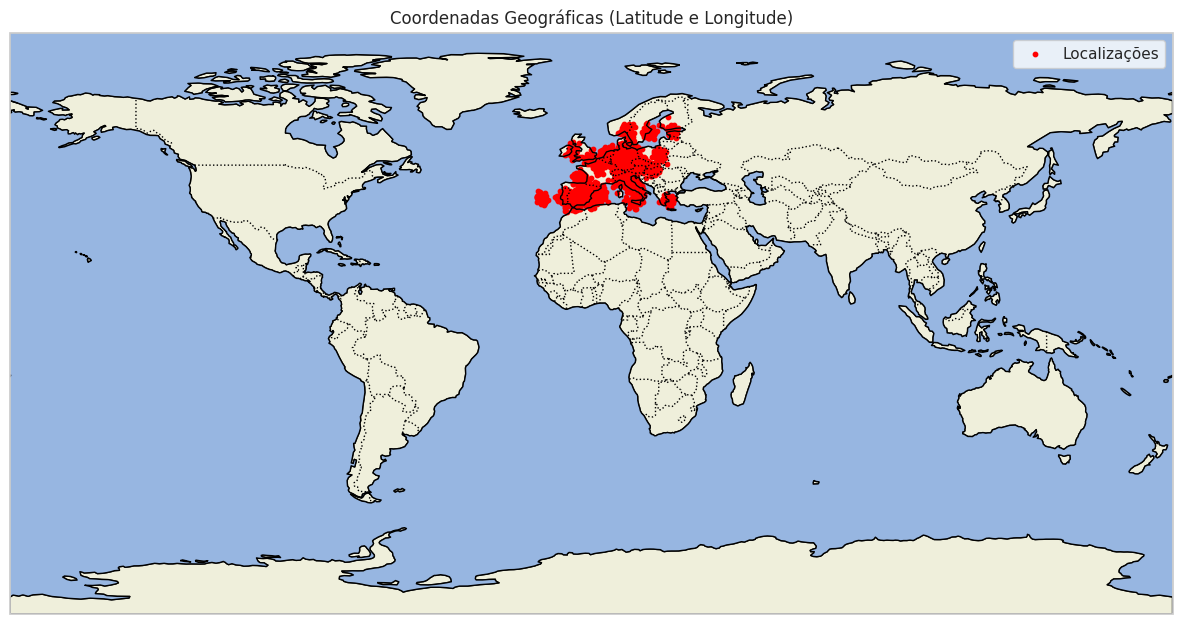

In [29]:
# Criando o plot com Cartopy
plt.figure(figsize=(15, 8))
ax = plt.axes(projection=ccrs.PlateCarree())  # Define a projeção para o gráfico
ax.set_extent([-180, 180, -90, 90])  # Define os limites do gráfico (global)

# Adiciona características ao mapa como costas, estados e países
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(cfeature.BORDERS, linestyle=':')
ax.add_feature(cfeature.LAND, edgecolor='black')
ax.add_feature(cfeature.OCEAN)

# Plotando as coordenadas no mapa
plt.scatter(terminal['x_terminal_id'], terminal['y_terminal_id'],
            color='red', marker='o', s=10, transform=ccrs.PlateCarree(),
            label='Localizações')

plt.title('Coordenadas Geográficas (Latitude e Longitude)')
plt.legend()
plt.show()